<a href="https://colab.research.google.com/github/Zolberg101/Edge-AI-Platform-Tutorials/blob/master/cifar_solo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import random
import numpy as np
import tensorflow as tf
import torchvision.datasets
import matplotlib.pyplot as plt
import shutil
import tqdm as tqdm
import torchvision
import time
import pandas as pn
# import cuda

In [0]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.determenistic = True

In [106]:
CIFAR_train = torchvision.datasets.CIFAR10('./', download=True, train=True)
CIFAR_test  = torchvision.datasets.CIFAR10('./', download=True, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
# nvidia-smi

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_test.targets)
X_test  = torch.FloatTensor(CIFAR_train.data)
y_test  = torch.LongTensor(CIFAR_test.targets)

In [110]:
len(X_train), len(y_test)

(50000, 10000)

In [111]:
X_train.min(), X_train.max()

(tensor(0.), tensor(255.))

In [0]:
X_train /= 255
X_test  /= 255

In [113]:
CIFAR_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

tensor(3)__tensor(8)__tensor(8)__tensor(0)__tensor(6)__tensor(6)__tensor(1)__tensor(6)__tensor(3)__tensor(1)__

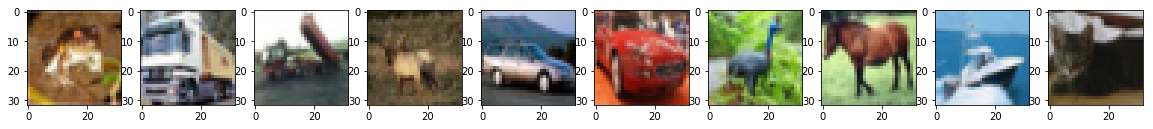

In [114]:
plt.figure(figsize=(20,2))
for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.imshow (X_train[i])
  print(y_train[i], end='__')

In [115]:
X_train.shape, y_train.shape

(torch.Size([50000, 32, 32, 3]), torch.Size([10000]))

In [0]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

In [117]:
X_train.shape, y_train.shape

(torch.Size([50000, 3, 32, 32]), torch.Size([10000]))

In [0]:
bat_s  = 100 #batch_size
nm     = 200 #number of epoch
l_r    = 1.0e-3 #learning rate
s_s    = 500 #step size
mmn    = 0.9 #momentum for SGD
gm     = 0.1

In [0]:
train_dataloader = torch.utils.data.DataLoader(
    X_train, batch_size=bat_s, shuffle=False, num_workers=bat_s)
val_dataloader   = torch.utils.data.DataLoader(
    X_test, batch_size=bat_s, shuffle=False, num_workers=bat_s)




In [120]:
len(train_dataloader), len(X_test)

(500, 50000)

In [0]:
def start_train(model, loss, optimizer, scheduler, num_epochs):
  for epoch in range(num_epochs):
    print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)
    
    for phase in [X_train, X_test]:
      if phase == X_train:
        dataloader = train_dataloader
        scheduler.step()
        model.train()
      else:
        dataloader = val_dataloader
        model.eval()
        
      running_loss = 0
      running_acc  = 0
      
      for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
    
      with torch.set_grad_enable(phase==X_test):
        preds = model(inputs)
        loss_value = loss(preds, labels)
        preds_class = preds.argmax(dim=1)
        
        if phase  == X_test:
          loss_value.backward()
          optimizer.step()
          
      running_loss += loss_value.item()
      running_acc  += (preds_class == labels.data).float().mean()
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc  = running_acc  / len(dataloader)
    loss_his = [epoch_loss]
    acc_his  = [epoch_acc ]
    print('{} Loss: {:.4f} Acc: [:.4f]'.format(phase, epoch_loss, epoch_acc), flush=True)
  
  return model
      

In [0]:
from torchvision import models
model = models.resnet18(pretrained=True)

for param in model.parameters():
  param.requires_grad = False
  
model.fc = torch.nn.Linear(model.fc.in_features, 10)

model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=l_r)
#optimezer = torch.optim.SGD(model.parameters(), lr=l_r, momentum = mmn)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=s_s, gamma = gm)

In [136]:
start_train(model, loss, optimizer, scheduler, num_epochs=nm)

Epoch 0/199:


RuntimeError: ignored

In [130]:
model.eval()
test_predictions = []
test_img_paths   = []
pred             = []
for inputs, labels, paths in tqdm(test_dataloader):
  inputs = inputs.to(device)
  labels = labels.to(device)
  with torch.set_grad_enable(False):
    preds = model(inputs)
  test_predictions.append(torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
  test_img_paths.extend(paths)
  pred=pred
test_predictions = np.concatenate(test_predictions)

NameError: ignored

In [0]:
# def train(net, X_train, y_train, X_test, y_test):
  
#   batch_size = bat_s
  
#   net = net.to(device)

#   loss = CrossEntropyLoss()
#   optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=l_r)
#   #optimizer = torch.optim.Adam(model.parameters(), lr=l_r, momentum = mmn)
#   #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=s_s, gamma=0.1)
  
#   acc_metric = []
#   loss_metric= []
  
#   X_test = X_test.to(device)
#   y_test = y_test.to(device)
  
#   for epoch in range(rng):
#     order = np.random.permutation(len(X_train))
#     for start_index in range(0, len(X_train), bat_s):
#       optimizer.zero_grad()
#       model.train()
      
#       batch_indexes = order[start_index:start_index+bat_s]
      
#       X_batch = X_train[batch_indexes].to(device)
#       y_batch = y_train[batch_indexes].to(device)
      
#       preds = model.forward(X_batch)
      
#       loss_value = loss(preds, y_batch)
#       loss.value.backward()
      
#       optimizer.step()
      
#       x_batch
#       net.eval()
#       test_preds = net.forward(X_test)
#       loss_metric.append(loss(test_preds, y_test).data.cpu())

#       accuracy = (test_preds.argmax(dim=1)==y_test).float().mean().data.cpu()
#       acc_metric.append(accuracy)

#       print(accuracy)
#   del net
#   return acc_metric, loss_metric




    